# Beta Lag Effects

In a traditional cap-m formulation, a security's return is blah blah blah. Lots of people know this. Add this later.

Some people claim beta lag effects exist. I'm here to find out.

## Duff & Phelps Valuation Handbook Methodology

The Duff & Phelps 2016 Valuation Handbook -- Guide to Cost of Capital is commonly cited by valuation experts. It states that a "beta lag" effect exists. A security's return in this period depends on the market return in this period and the security's return in a prior period.

### Lag effects

> **For all but the largest companies, the prices of individual stocks tend to react in part to movements in the overall market with a lag. The smaller the company, generally the greater the lag in the price reaction.** This does not necessarily imply that the market itself is wholly inefficient, although the market for some stocks is more efficient than for other stocks. Large companies tend to be followed by more analysts and are owned by more institutional investors than are small-cap companies. Therefore, large-cap companies tend to react more quickly to changes in the economy or changes in the business.

> Because of the lag […], traditional OLS betas tend to understate systematic risk. A sum beta consists of a multiple regression of a stock's current month's excess returns [...][and] the market's previous month's excess returns, and then a summing of the resulting coefficients. This helps to capture more fully the lagged effect of co-movement in a company's returns with returns on the market.”

Valuators take the concept of Beta qua the concept of Beta, but if material beta lag effects exist, then it should be trivial to estimate future price movements.

Several examples are included from the book:

| Company | Market Cap ($MM) | OLS Beta | Sum Beta | Difference|
|:-------:|:----------------:|:--------:|:--------:|:---------:|
|AT&T, Inc.|211,690.32|0.36|0.36|0.00|
|The Boeing Company|96,872.933|1.01|1.05|0.04|
|FedEx Corporation|41,063.916|1.22|1.3|0.08|
|Lululemon Athletica Inc.|7,269.908|0.81|0.93|0.12|
|Steven Madden, Ltd.|1,891.08|1.02|1.35|0.33|
|Briggs & Stratton Corporation|765.093|1.01|1.36|0.35|
|Almost Family Inc.|375.533|1.42|1.87|0.45|
|StealthGas, Inc.|142.422|1.34|1.57|0.24|

For the \$100MM to \$1B range, it appears as though there is a very significant, positive sum beta.

### Forward Looking Betas

The book argues that, in a predictive sense, betas move toward the market or industry average. Bloomberg and Value Line weight historical betas with the market beta (1.0 by definition) by 2/3 and 1/3, respectively. A more sophisticated technique, Vasicek shrinkage, is also suggested, but not completely explained. It sometimes weights betas to the market average and sometimes to a sector's industry average. Case law and common sense suggest the latter is perhaps more accurate.


### Other Details

For Duff & Phelps, periods are defined as months, but they state that weeks should give similar results. They are based on a five year historical sample. Returns are defined as "excess returns," that is, in excess of the risk free rate. They state that using full returns (rather than excess returns) will produce similar results. Given how stable and low the risk free rate has been lately, I'm skipping this step.

# Full Universe Weekly Beta Calculation
This notebook will study the parameters of 6 different weekly models:

| Dep var: | With Earnings | Without Earnings |
|:--------:|:-------------:|:----------------:|
| ret_cc   | Model 1       | Model 2          |
| ret_oc   | Model 3       | Model 4          |
| ret_co   | Model 5       | Model 6          |

The dependent variable will indicate the beginning and end of the testing period. ret_cc measures from close to close. ret_oc measures from open to close (i.e. while the market is open), etc.

In even numbered models, the weeks of earnings releases and the subsequent weeks are removed from the data set.

Each model will be run over the following time periods:

1. 2011
1. 2012
1. 2013
1. 2014
1. 2015
1. 2011 - 2015

## Key Questions:

1. Does the beta-lag effect exist in all models?
1. Are the companies which display beta-lags consistent from year to year?
1. Is the effect robust to earnings?
1. Does it occur in both large and small companies?

# Setup
## Import Packages

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data
import statsmodels.formula.api as sm
import time
import wmcm
import seaborn as sns
%matplotlib inline
import finsymbols

Matplotlib is building the font cache using fc-list. This may take a moment.
Matplotlib is building the font cache using fc-list. This may take a moment.


## Define Universe
The tickers associated with the NYSE and the NASDAQ were pulled using the finsymbols package.

In [2]:
nyse = pd.DataFrame(finsymbols.get_nyse_symbols())
nyse['exchange'] = 'nyse'
nasdaq = pd.DataFrame(finsymbols.get_nasdaq_symbols())
nasdaq['exchange'] = 'nasdaq'
universe = pd.concat([nyse, nasdaq])
universe['symbol'] = universe['symbol'].replace('.', '-')
universe.head()

,company,industry,sector,symbol,exchange
0,3D Systems Corporation,Computer Software: Prepackaged Software,Technology,DDD,nyse
1,3M Company,Medical/Dental Instruments,Health Care,MMM,nyse
2,500.com Limited,Services-Misc. Amusement & Recreation,Consumer Services,WBAI,nyse
3,58.com Inc.,Computer Software: Programming,Technology,WUBA,nyse
4,A.H. Belo Corporation,Newspapers/Magazines,Consumer Services,AHC,nyse


## Pull Universe

In [4]:
# Uncomment these lines the first time notebook run on computer. Full price data isn't uploaded to github.

# stocks = wmcm.Universe(universe['symbol'], 'SPY', interval='w', verbose=False)

# stocks.save('pickle/full_price_history.p')

stocks = wmcm.Universe.load('pickle/full_price_history.p')

No Earnings Data found for GCH!
No Earnings Data found for JEQ!
No Earnings Data found for SGF!
No Earnings Data found for ADX!
No Earnings Data found for PEO!
No Earnings Data found for AGRO!
No Earnings Data found for AVK!
No Earnings Data found for AGC!
No Earnings Data found for LCM!
No Earnings Data found for AEB!
No Earnings Data found for AED!
No Earnings Data found for AEH!
No Earnings Data found for AEK!
No Earnings Data found for MGR!
No Earnings Data found for AFSD!
Some other Error occured for MITT^A
Some other Error occured for MITT^B
ValueError occured for AYR
Some other Error occured for ALP^O
Some other Error occured for AA^B
Some other Error occured for ALR^B
Some other Error occured for ARE^D
Some other Error occured for ARE^E
Some other Error occured for AGN^A
No Earnings Data found for AKP!
No Earnings Data found for AFB!
No Earnings Data found for AWF!
No Earnings Data found for NCV!
No Earnings Data found for NCZ!
No Earnings Data found for NIE!
No Earnings Data f

FileNotFoundError: [Errno 2] No such file or directory: 'pickle/full_price_history.p'

In [5]:
stocks['GOOG']

Stock : GOOG
        Starting Date : 2011-01-01 00:00:00
        Ending Date : 2015-12-31 00:00:00
        Frequency : w

In [6]:
stocks['YCB']

Stock : YCB
        Starting Date : 2011-01-01 00:00:00
        Ending Date : 2015-12-31 00:00:00
        Frequency : w

## Prepare Analysis Dataframes

In [6]:
for key in list(stocks.keys()): #list(stock.keys()) allows you to delete while iterating
    if key=='market':
        continue
    if len(stocks[key].earnings_df.index)==0: # Have to remove stocks without earnings.
        del stocks[key]
    else:
        stocks[key].analysis_df = stocks[key].adj_returns
        stocks[key].analysis_df['lagged_ret_cc'] = stocks[key].analysis_df['ret_cc'].shift(1)
        stocks[key].analysis_df = stocks[key].analysis_df.loc[(stocks[key].analysis_df['earnings_period'].shift(1)==False)]

stocks['market'].analysis_df = stocks['market'].adj_returns

# Fit Models
## Model 1

using a non-integer number instead of an integer will result in an error in the future


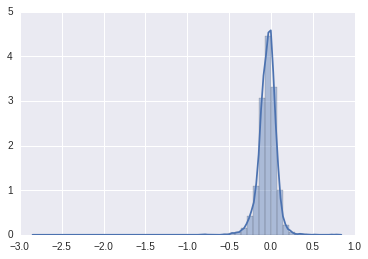

In [22]:
stocks.factor_model_all('ret_cc ~ ret_cc_market + lagged_ret_cc', filter_earnings=False)
stocks.model_1 = stocks.results
plot_data = pd.DataFrame({stock : stocks.model_1[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 2

using a non-integer number instead of an integer will result in an error in the future


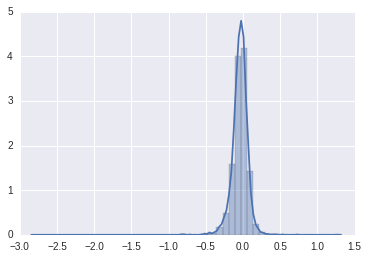

In [23]:
stocks.factor_model_all('ret_cc ~ ret_cc_market + lagged_ret_cc', filter_earnings=True)
stocks.model_2 = stocks.results
stocks.model_2['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_2[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 3

using a non-integer number instead of an integer will result in an error in the future


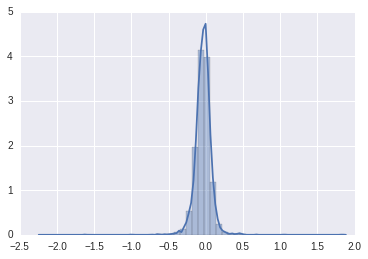

In [24]:
stocks.factor_model_all('ret_oc ~ ret_oc_market + lagged_ret_cc', filter_earnings=False)
stocks.model_3 = stocks.results
stocks.model_3['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_3[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 4

using a non-integer number instead of an integer will result in an error in the future


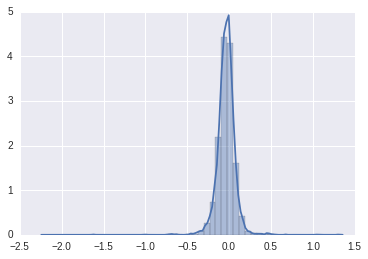

In [25]:
stocks.factor_model_all('ret_oc ~ ret_oc_market + lagged_ret_cc', filter_earnings=True)
stocks.model_4 = stocks.results
stocks.model_4['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_4[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 5

using a non-integer number instead of an integer will result in an error in the future


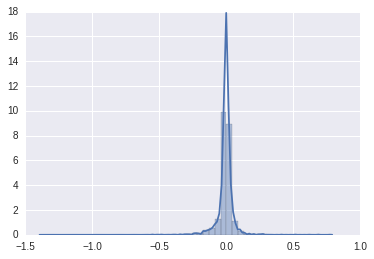

In [26]:
stocks.factor_model_all('ret_co ~ ret_co_market + lagged_ret_cc', filter_earnings=False)
stocks.model_5 = stocks.results
stocks.model_5['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_5[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 6

using a non-integer number instead of an integer will result in an error in the future


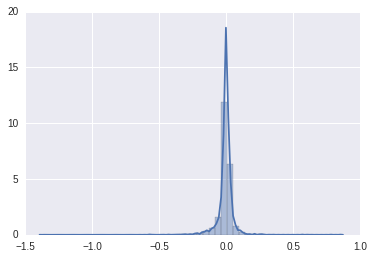

In [27]:
stocks.factor_model_all('ret_co ~ ret_co_market + lagged_ret_cc', filter_earnings=True)
stocks.model_6 = stocks.results
stocks.model_6['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_6[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)